In [264]:
import os
import json
import numpy as np

import torch
import torch.nn as nn
from torch.optim import AdamW
import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.models import resnet18
import torchvision
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor, Lambda

In [265]:
save_dir = r"C:\Users\dra04\fashion image\K-Fashion 이미지\Training\라벨링데이터"
image_dir = r"C:\Users\dra04\fashion image\K-Fashion 이미지\Training\원천데이터"

json_files = []
image_files=[]
for file in os.listdir(save_dir):
    json_files.append(os.path.join(save_dir, file))
    image_files.append(os.path.splitext(file)[0])

print("데이터 개수:", len(json_files))
print("이미지 개수:", len(image_files))
image_files[0]

데이터 개수: 3636
이미지 개수: 3636


'100004'

clothes_class = ["아우터", "하의", "원피스", "상의"]
clothes_xy = {"outer_xy":None, "pants_xy":None, "onepiece_xy":None, "shirt_xy":None}
clothes_fabric = {"outer_fabric":None, "pants_fabric":None, "onepiece_fabric":None, "shirt_fabric":None}

image_dict = {}

for file in json_files:
    with open(file, "rb") as f:
        data = json.load(f)
        file_name = data['이미지 정보']['이미지 파일명']
        for cls, xy, fabric in zip(clothes_class, clothes_xy, clothes_fabric):
            clothes_xy[xy] = data['데이터셋 정보']['데이터셋 상세설명']['렉트좌표'][cls][0].values()
            if not clothes_xy[xy]:
                continue
            try:
                clothes_fabric[fabric] = data['데이터셋 정보']['데이터셋 상세설명']['라벨링'][cls][0]['소재']
            except:
                print(file_name) #소재 없는 파일 
                print("--------------------")
        #print(clothes_xy)
        #print(clothes_fabric)

    for xy, fabric in zip(clothes_xy.values(), clothes_fabric.values()):
        if not xy:
            continue
        image_dict[(file_name, xy)] = fabric

image_dict

In [272]:
clothes_class = ["아우터", "하의", "원피스", "상의"]
clothes_xy = {"outer_xy":None, "pants_xy":None, "onepiece_xy":None, "shirt_xy":None}
clothes_fabric = {"outer_fabric":None, "pants_fabric":None, "onepiece_fabric":None, "shirt_fabric":None}

image_dict = {}

for file in tqdm(json_files):
    if os.path.splitext(file.split("\\")[-1])[0] not in image_files: #이미지 파일 없을 때
        continue
    with open(file, "rb") as f:
        data = json.load(f)
        file_id = data['이미지 정보']['이미지 식별자']
        file_name=str(data['이미지 정보']['이미지 식별자'])+'.jpg'
        for cls, xy, fabric in zip(clothes_class, clothes_xy, clothes_fabric):
            clothes_xy[xy] = data['데이터셋 정보']['데이터셋 상세설명']['렉트좌표'][cls][0].values()
            if not clothes_xy[xy]:
                continue
#             if list(clothes_xy[xy])[2] < 1 or list(clothes_xy[xy])[3] < 1:
#                 print(file)
#                 continue
            try:
                clothes_fabric[fabric] = data['데이터셋 정보']['데이터셋 상세설명']['라벨링'][cls][0]['소재']
            except:
                pass
#                 print(file_name) #소재 없는 파일 
#                 print("--------------------")
        #print(clothes_xy)
        #print(clothes_fabric)

    for xy, fabric in zip(clothes_xy.values(), clothes_fabric.values()):
        if not xy:
            continue
        if list(xy)[2] < 1 or list(xy)[3] < 1:
            continue
        image_dict[(file_name, xy)] = fabric

image_dict

100%|█████████████████████████████████████████████████████████████████████████████| 3636/3636 [00:12<00:00, 301.36it/s]


{('100004.jpg', dict_values([361.004, 52.4333, 197, 506])): ['우븐'],
 ('100005.jpg', dict_values([303.085, 39.4514, 186, 497])): ['우븐'],
 ('100006.jpg', dict_values([238.203, 3.5, 300, 381])): ['우븐'],
 ('100006.jpg', dict_values([315.068, 231.407, 173, 465])): ['우븐'],
 ('100006.jpg', dict_values([370.203, 23.5, 57, 214])): ['우븐'],
 ('100007.jpg', dict_values([268.133, 1.50416, 262, 591])): ['우븐'],
 ('100012.jpg', dict_values([297.093, 43.4458, 192, 497])): ['우븐'],
 ('100013.jpg', dict_values([232.203, -0.5, 306, 389])): ['우븐'],
 ('100013.jpg', dict_values([306.081, 230.408, 185, 481])): ['우븐'],
 ('100013.jpg', dict_values([364.203, 23.5, 59, 215])): ['우븐'],
 ('100014.jpg', dict_values([355.012, 29.4653, 191, 517])): ['우븐'],
 ('100015.jpg', dict_values([303.085, 21.4764, 188, 514])): ['우븐'],
 ('100016.jpg', dict_values([289.104, 191.462, 197, 497])): ['우븐'],
 ('100016.jpg', dict_values([243.168, 5.4986, 284, 209])): ['니트'],
 ('100021.jpg', dict_values([28.4667, 56.4278, 187, 475])): ['우븐

In [273]:
class ClothDataset(Dataset):
    def __init__(self, image_dict, data_dir=r"C:\Users\dra04\fashion image\원천데이터"): #C:\Users\dra04\fashion image\K-Fashion 이미지\Training\원천데이터
        super().__init__()
        self.data_dir = data_dir
        self.image_dict = image_dict
        self.image_files = []
        self.dict_label_to_num = {
            "퍼" : 0,
            "니트" : 1,
            "무스탕" : 2,
            "레이스" : 3,
            "스웨이드" : 4,
            "린넨" : 5,
            "앙고라" : 6,
            "메시" : 7,
            "코듀로이" : 8,
            "플리스" : 9,
            "시퀸/글리터" : 10,
            "네오프렌" : 11,
            "데님" : 12,
            "실크" : 13,
            "저지" : 14,
            "스판덱스" : 15,
            "트위드" : 16,
            "자카드" : 17,
            "벨벳" : 18,
            "가죽" : 19,
            "비닐/PVC" : 20,
            "면" : 21,
            "울/캐시미어" : 22,
            "시폰" : 23,
            "합성섬유" : 24,
            "우븐" : 25,
            "패딩" : 26
        }
        self.setup()

    def setup(self):
        for (file_name, xy), fabric in self.image_dict.items():
            if not fabric:
                continue
            self.image_files.append((os.path.join(self.data_dir, file_name), xy, fabric))

    def __getitem__(self, idx):
        file_name, xy, fabric = self.image_files[idx]
        fabric=fabric[0]
        x, y, w, h = map(int, xy)
#         for i in [x, y, w, h]:
#             if i < 1:
#                 i = 1
        
        im = Image.open(file_name)
        im = transforms.ToTensor()(im)
        im = torchvision.transforms.functional.crop(im, y, x, h, w)
        im = transforms.Resize((5,5))(im)

        fabric_label = self.dict_label_to_num[fabric]
        return im, fabric_label
    
    def __len__(self):
        return len(self.image_files)



In [274]:
dataset = ClothDataset(image_dict)
print(len(dataset))
# dataset[7]

4574


In [275]:
import torch.nn.functional as F

class Resnet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.fc = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return self.fc(x)

    
#     class ClothModel(nn.Module):
#         def __init__(self, num_classes=27):
#             super().__init__()

#         self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
#         self.dropout1 = nn.Dropout(0.25)
#         self.dropout2 = nn.Dropout(0.25)
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(128, num_classes)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)

#         x = self.conv2(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)

#         x = self.conv3(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)
#         x = self.dropout2(x)

#         x = self.avgpool(x)
#         x = x.view(-1, 128)
#         return self.fc(x)

In [276]:
BATCH_SIZE = 16
EPOCHS =5
LOG_INTERVAL=100
LEARNING_RATE=0.001
SAVE_DIR="./results"

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader=DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True,shuffle=True)

model = Resnet18(num_classes=27)

criterion=nn.CrossEntropyLoss()

#optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1)


for epoch in range(EPOCHS):
    model.train()
    loss_value=0
    matches=0
    for idx, batch in enumerate(tqdm(train_loader)): #train_loader
        inputs, labels=batch
        inputs=inputs.to(device)

        labels=labels.to(device)

        optimizer.zero_grad()

        outs=model(inputs)
        preds=torch.argmax(outs,dim=-1)
        loss=criterion(outs, labels)

        loss.backward()
        optimizer.step()

        loss_value += loss.item()
        matches += (preds==labels).sum().item()
        if(idx+1) % LOG_INTERVAL==0:
            train_loss=loss_value / LOG_INTERVAL
            train_acc=matches / BATCH_SIZE / LOG_INTERVAL
            print(
                f"Epoch[{epoch}/{EPOCHS}]({idx + 1}/{len(train_loader)}) || " #train_loader
                f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%}"
            )
            loss_value = 0
            matches = 0
    #        

    #    
    

 35%|████████████████████████████                                                    | 100/285 [02:20<04:10,  1.35s/it]

Epoch[0/5](100/285) || training loss 2.144 || training accuracy 46.56%


 70%|████████████████████████████████████████████████████████▏                       | 200/285 [05:24<05:22,  3.79s/it]

Epoch[0/5](200/285) || training loss 2.003 || training accuracy 47.19%


 33%|██████████████████████████▋                                                      | 94/285 [05:08<10:26,  3.28s/it]


KeyboardInterrupt: 

In [108]:
import os
currentPath=os.getcwd()
print(currentPath)
#os.chdir("C:\Users\dra04\fashion image\원천데이터")
#files=os.listdir(currentPath)
#print("Files in %r: %s" %(currentPath, files))
#plt.imshow(dataset[1][0].permute(1, 2, 0))

C:\Users\dra04\fashion image


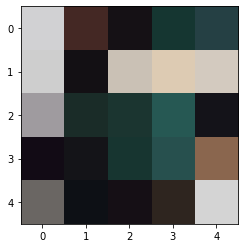

In [277]:
idx = np.random.randint(0, 3000)
plt.imshow(dataset[idx][0].permute(1,2,0))

In [232]:
for i, j in image_dict.items():
    im, dict_val = i
    x, y, h, w = dict_val
    if h == 0 or w == 0:
        print(i)
        print(j)

('85320.jpg', dict_values([225.5, 147.5, 0, 0]))
['니트']


In [278]:
image_dict['85320.jpg', dict_values([225.5, 147.5, 0, 0])]

NameError: name 'dict_values' is not defined